In [74]:
from collections import Container
import os
import warnings 
import torch
import cv2
import json
import numpy as np
from pycocotools.coco import COCO
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import skimage.io as io

%matplotlib inline
# plt.rcParams["figure.figsize"] = (20, 15)

In [75]:
dataset_dir = "/opt/ml/segmentation/input/data/"
train_json_dir = dataset_dir + "train_all.json"

In [76]:
dataset_path = "../../input/data"

train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json' # example path
test_path = dataset_path + '/test.json' # example path

coco = COCO(train_path) # COCO API를 사용하기 위한 선언 val_path,test_path도 가능하다.
with open(train_json_dir, 'r') as f: # json을 dict로 읽어오게 가져옴.
    train_json = json.loads(f.read())
    
images = train_json['images'] # image의 license, url, file_name, heightm width, date_captured가 저장되어있다.
categories = train_json['categories'] # category의 id, name, supercategory가 저장되어있다.
annotations = train_json['annotations'] # image마다의 annotation의 id, image_id, category_id, segmentation, area, bbox, iscrowd가 저장되어있다.

# categories_names: category_id와 이름을 매핑해주는 변수
categories_names = ['Back Ground'] # 0에는 Background가 저장되어 있어야하지 않을까...?
for cat_dict in categories:
    categories_names.append(cat_dict['name'])

loading annotations into memory...
Done (t=4.17s)
creating index...
index created!


In [77]:
def category_id_to_color(category_id):
    '''
    카테고리에 해당하는 색상을 return 해주는 함수.
    '''
    return plt.cm.rainbow(np.linspace(0, 1.0, 11)[category_id])[:3]

def visualization_with_matplotlib(*args): 
    idx = []
    for i in args:
        if issubclass(type(i), Container):
            for j in i:
                idx.append(j)
        else:
            idx.append(i)

    fig, axs = plt.subplots(1*len(idx),2,figsize=(10,5*len(idx)),constrained_layout=True)
    axs = axs.flatten() # 개꿀팁;
    for idx, i in enumerate(idx):
        axs[idx*2].set_title(f'Original image(idx : {i})')
        axs[idx*2+1].set_title(f'Ground Truth image(idx : {i})')

        legend_colors = []  # 사진에 포함된 카테고리에 해당하는 색상을 저장 (추후 범례 표시를 위해)
        legend_titles = [] # 사진에 포함된 카테고리 이름을 저장 (추후 범례 표시를 위해)
        image_id = coco.getImgIds(imgIds=i)
        image_infos = coco.loadImgs(image_id)[0]

        ann_ids = coco.getAnnIds(imgIds=i)
        ann = coco.loadAnns(ann_ids)

        img = io.imread(os.path.join(dataset_dir, images[idx]['file_name']))
        axs[idx*2].grid(False)
        axs[idx*2].imshow(img)
    
        mask = np.zeros((image_infos['height'],image_infos['width'],3))
        for element in ann:
            category_id = element['category_id']
            category = categories_names[category_id]
            color = category_id_to_color(category_id)
            mask[coco.annToMask(element) == 1] = color
            if category not in legend_titles:
                legend_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
                legend_titles.append(category)
        axs[idx*2+1].legend(legend_colors, legend_titles, loc='lower right', framealpha=.5)
        axs[idx*2+1].grid(False)
        axs[idx*2+1].imshow(mask)
            # axs[idx,1].legend()


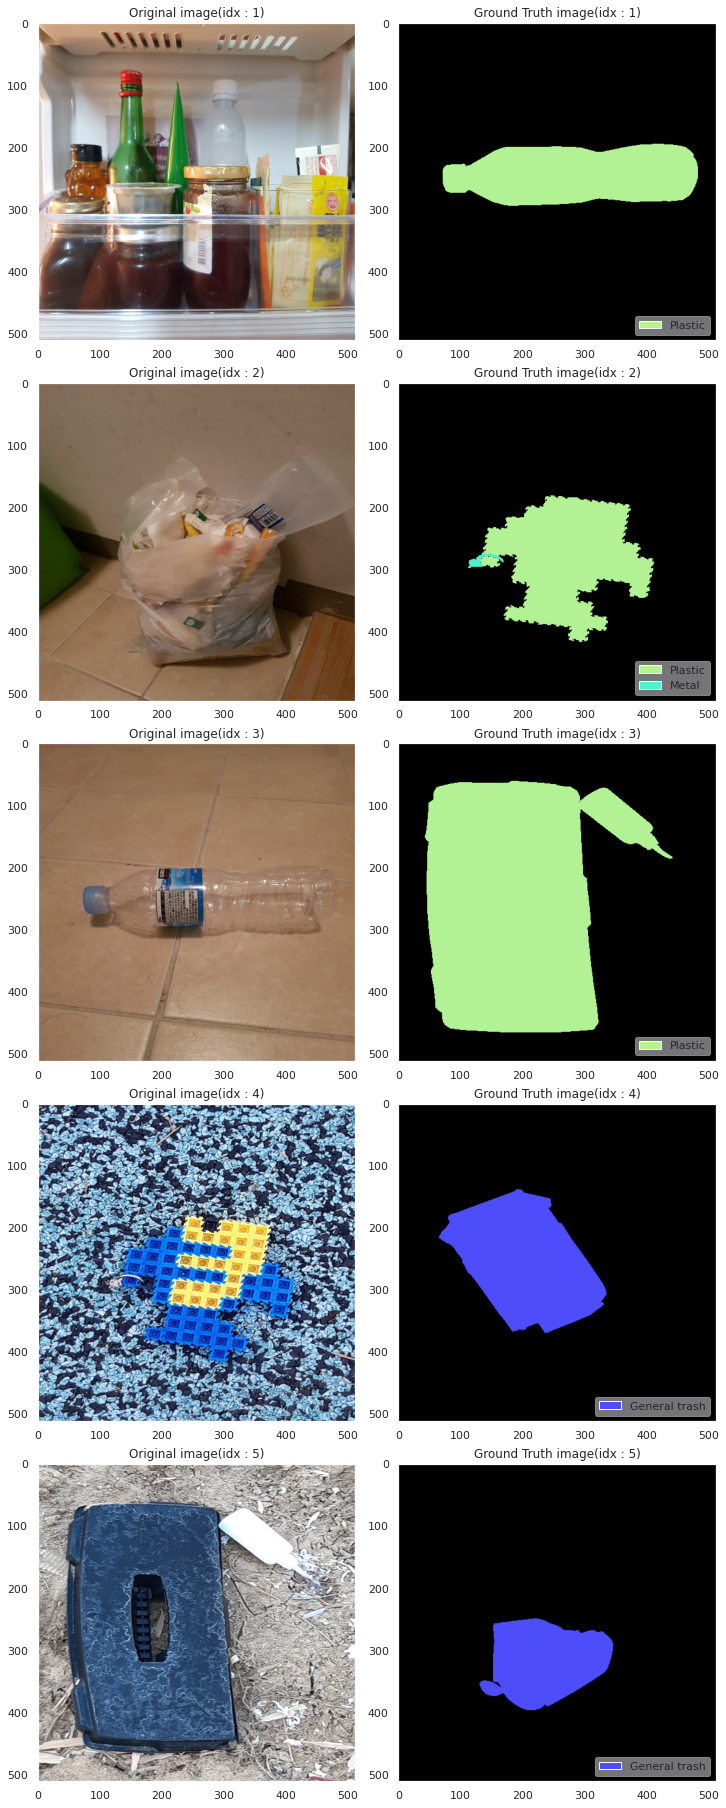

In [78]:
visualization_with_matplotlib([1,2,3,4,5]) # 실행하는 함수 argment는 저렇게 넣어도 된다.